In [1]:
from surprise import Reader, Dataset, SVD, accuracy, KNNBasic, BaselineOnly, NormalPredictor, KNNWithMeans, SVDpp, Trainset
from surprise.model_selection import cross_validate, train_test_split, KFold
from surprise.accuracy import rmse, mae, mse
from surprise.similarities import cosine
from surprise.prediction_algorithms.predictions import Prediction
from collections import namedtuple, defaultdict
from scipy.stats import gaussian_kde, norm
from scipy.integrate import quad
import pandas as pd
import itertools
import datetime
import numpy as np
from matplotlib import pyplot as plt
import os
import seaborn as sns
import time
import csv
import heapq

In [85]:
pd.set_option('display.precision', 15)
submit = False

In [43]:
import warnings
warnings.filterwarnings("ignore") #holamundo

## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics, preprocessing

## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)

In [44]:
# rentabilidad = pd.read_csv('/kaggle/input/datathon/RentabilidadProduct.csv',sep='|')
# submit_example = pd.read_csv('/kaggle/input/datathon/submit_example.csv')
# data = pd.read_csv('/kaggle/input/datathon/train.csv',sep='|')

rentabilidad=pd.read_csv('RentabilidadProduct.csv', sep='|')
#submit_example=pd.read_csv('submission_all.csv', sep='|')
data= pd.read_csv('train.csv', sep='|')

print('data', data.shape)
print('rentabilidad',rentabilidad.shape)
#print('submit_example',submit_example.shape)

data (2167848, 9)
rentabilidad (937, 6)


In [45]:
data.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf
0,2022-01-31,7157,510,BO,21,V,1.0,0.153430522427944,0.005210847931515
1,2022-01-31,7157,512,BO,21,V,1.0,0.153430522427944,0.005210847931515
2,2022-01-31,9382,510,BO,21,V,1.0,0.153430522427944,0.005210847931515
3,2022-01-31,9382,512,BO,21,V,1.0,0.153430522427944,0.005210847931515
4,2022-01-31,9382,525,BO,21,V,1.0,0.153430522427944,0.005789831035017


In [46]:
rentabilidad.head()

,product_id,family_id,negocio_id,category_id,tier_id,utilidad_bruta_transf
0,881,1291,20,131,4,10.378016570
1,805,1224,20,131,3,10.177925190
2,892,1089,20,146,1,10.008242890
3,841,1224,20,131,3,7.698361552
4,830,1089,20,131,1,7.353677620


In [47]:
df=data.merge(rentabilidad, on='product_id', how='inner')
df['fecha_compra']= pd.to_datetime(df['fecha_compra'], format = '%Y-%m-%d', errors = 'coerce')
# df['y']=(df.cantidad_venta*df.monto_venta_transf)
df.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,family_id,negocio_id,category_id,tier_id,utilidad_bruta_transf
0,2022-01-31,7157,510,BO,21,V,1.0,0.153430522427944,0.005210847931515,1427,20,173,2,-0.306416197
1,2022-01-31,9382,510,BO,21,V,1.0,0.153430522427944,0.005210847931515,1427,20,173,2,-0.306416197
2,2022-01-31,10355,510,BO,21,V,1.0,0.153430522427944,0.005210847931515,1427,20,173,2,-0.306416197
3,2022-01-31,10394,510,BO,21,V,12.0,1.771688296715124,0.062530175178181,1427,20,173,2,-0.306416197
4,2022-01-31,304,510,BO,21,V,12.0,1.829586607065291,0.062530175178181,1427,20,173,2,-0.306416197


In [48]:
from datetime import timedelta
import pandas as pd
d=df.fecha_compra.min()+timedelta(days=-1)
list_dates=[]
semana_dates=[]
i=1
for y in range(0,60):
    for x in range(0,7):
        d=d+timedelta(days=1)
        a='semana'+str(i)
        semana_dates.append(a)
        list_dates.append(d)
    i=i+1
calendar=pd.DataFrame()
calendar['semana_dates'] = semana_dates
calendar['list_dates'] = list_dates

In [49]:
dtf_products=df.merge(calendar, left_on='fecha_compra', right_on='list_dates', how='inner')

t=pd.DataFrame(dtf_products.utilidad_bruta_transf)
mm_scaler = preprocessing.MinMaxScaler()
utilidad_bruta_transf_mm = mm_scaler.fit_transform(t)
utilidad_bruta_transf_mm = pd.DataFrame(utilidad_bruta_transf_mm)
dtf_products['utilidad_bruta_transf_mm']=utilidad_bruta_transf_mm

In [50]:
dtf_products['semana_dates']='semana0'

In [51]:
dtf_products['utilidad_bruta_transf_mm'].isnull().sum()

0

In [52]:
df2=dtf_products.groupby(['semana_dates', 'customer_id','product_id','tier_id','family_id','negocio_id','category_id']).agg({
         'monto_venta_transf':sum,    # 
         'cantidad_venta': sum,  # 
         'peso_venta_transf': sum,  # 
         'fecha_compra': "count",  #
         'utilidad_bruta_transf_mm': "median"  #
    }).reset_index()
df2.rename(columns={'fecha_compra':'frequencia'},inplace=True)

In [53]:
# ---------------------------------------
# Construcción de Data Set [User - Item]
# ---------------------------------------

# Base de datos suma de monto y trx total por cliente:
copy = pd.DataFrame()
copy = df2.copy()
tempMontoTot = pd.DataFrame()
tempMontoTot['montoTot'] = copy.groupby(['customer_id', 'semana_dates']).agg('monto_venta_transf').sum()
tempMontoTot['trxTot'] = copy.groupby(['customer_id','semana_dates']).agg('frequencia').sum()
#agregado sandy***************************************************************
tempMontoTot['cantTot'] = copy.groupby(['customer_id', 'semana_dates']).agg('cantidad_venta').sum()
tempMontoTot['pesoTot'] = copy.groupby(['customer_id','semana_dates']).agg('peso_venta_transf').sum()
tempMontoTot['renTot'] = copy.groupby(['customer_id','semana_dates']).agg('utilidad_bruta_transf_mm').sum()
#agregado sandy***************************************************************
tempMontoTot = tempMontoTot.reset_index()
tempMontoTot.head()

,customer_id,semana_dates,montoTot,trxTot,cantTot,pesoTot,renTot
0,1,semana0,4215.025942647364900,768,3033.0,457.310962267004470,29.333092957843256
1,2,semana0,490.966092107349823,77,410.0,54.047783220329549,9.497979767640228
2,3,semana0,635.393427275842555,155,892.0,56.425377334859171,11.057373359412024
3,4,semana0,462.436699682304834,48,312.0,39.745742597631192,5.411344457329792
4,5,semana0,1506.377974282033847,302,954.0,188.512556126868901,31.381974451313798


In [54]:
# Base de datos suma de monto y trx total por cliente y comercio:
copy = pd.DataFrame()
copy = df2.copy()
tempMontoProducto = pd.DataFrame() 
tempMontoProducto['montoProducto'] = copy.groupby(['customer_id','product_id','semana_dates']).agg('monto_venta_transf').sum()
tempMontoProducto['trxProducto'] = copy.groupby(['customer_id','product_id','semana_dates']).agg('frequencia').sum()
#agregado sandy***************************************************************
tempMontoProducto['cantProducto'] = copy.groupby(['customer_id','product_id','semana_dates']).agg('cantidad_venta').sum()
tempMontoProducto['pesoProducto'] = copy.groupby(['customer_id','product_id','semana_dates']).agg('peso_venta_transf').sum()
tempMontoProducto['renProducto'] = copy.groupby(['customer_id','product_id','semana_dates']).agg('utilidad_bruta_transf_mm').sum()
#agregado sandy***************************************************************
tempMontoProducto = tempMontoProducto.reset_index()

print('****************************')
print('  Dimensiones User - Item')
print('****************************')

cliUn = tempMontoTot.shape[0]
comUn = tempMontoProducto[['product_id','semana_dates']].drop_duplicates().shape[0]
dimDb = tempMontoProducto.shape
print('1. Clientes únicos: '+str(cliUn))
print('2. Productos únicos: '+str(comUn))
print('3. DataSet Cliente X Producto: '+str(dimDb)+'\n')
print(tempMontoProducto.columns)

****************************
  Dimensiones User - Item
****************************
1. Clientes únicos: 15312
2. Productos únicos: 932
3. DataSet Cliente X Producto: (608684, 8)

Index(['customer_id', 'product_id', 'semana_dates', 'montoProducto',
       'trxProducto', 'cantProducto', 'pesoProducto', 'renProducto'],
      dtype='object')


In [55]:
# ------------------------
# Construyendo el Ranking
# ------------------------

## Cálculo de Peso del userXitem en base al monto y transacción por cliente - comercio:
dbMerge = pd.merge(tempMontoProducto, tempMontoTot, on =['customer_id','semana_dates'], how = 'left')
dbMerge['preRating_1'] = (dbMerge['montoProducto']/dbMerge['montoTot'])*(dbMerge['trxProducto']/dbMerge['trxTot'])
#agregado sandy***************************************************************
dbMerge['preRating_2'] = (dbMerge['cantProducto']/dbMerge['cantTot'])*(dbMerge['montoProducto']/dbMerge['montoTot'])*(dbMerge['pesoProducto']/dbMerge['pesoTot'])
dbMerge['preRating_3'] = ((dbMerge['cantProducto']/dbMerge['cantTot'])*(dbMerge['renProducto']/dbMerge['renTot'])*(dbMerge['trxProducto']/dbMerge['trxTot']))/((dbMerge['montoProducto']/dbMerge['montoTot'])*(dbMerge['pesoProducto']/dbMerge['pesoTot']))
dbMerge['preRating_4'] = ((dbMerge['cantProducto']/dbMerge['cantTot'])*(dbMerge['renProducto']/dbMerge['renTot'])*(dbMerge['montoProducto']/dbMerge['montoTot'])*(dbMerge['trxProducto']/dbMerge['trxTot']))/((dbMerge['pesoProducto']/dbMerge['pesoTot']))
dbMerge['preRating_5'] = (dbMerge['cantProducto']/dbMerge['cantTot'])*(dbMerge['renProducto']/dbMerge['renTot'])*(dbMerge['montoProducto']/dbMerge['montoTot'])*(dbMerge['trxProducto']/dbMerge['trxTot'])
#agregado sandy***************************************************************

# Creación del "Rating Final" a una escala de [0-1]
copy = pd.DataFrame()
copy = dbMerge.copy()
tempRatingTot = pd.DataFrame()

tempRatingTot['sumaPreRat_1'] = copy.groupby(['customer_id', 'semana_dates']).agg('preRating_1').sum()
#agregado sandy***************************************************************
tempRatingTot['sumaPreRat_2'] = copy.groupby(['customer_id', 'semana_dates']).agg('preRating_2').sum()
tempRatingTot['sumaPreRat_3'] = copy.groupby(['customer_id', 'semana_dates']).agg('preRating_3').sum()
tempRatingTot['sumaPreRat_4'] = copy.groupby(['customer_id', 'semana_dates']).agg('preRating_4').sum()
tempRatingTot['sumaPreRat_5'] = copy.groupby(['customer_id', 'semana_dates']).agg('preRating_5').sum()
#agregado sandy***************************************************************
tempRatingTot = tempRatingTot.reset_index()

dataBaseInputPre = pd.merge(dbMerge, tempRatingTot, on=['customer_id', 'semana_dates'], how='left')
dataBaseInputPre['rating_1'] = dataBaseInputPre['preRating_1']/dataBaseInputPre['sumaPreRat_1']
#agregado sandy***************************************************************
dataBaseInputPre['rating_2'] = dataBaseInputPre['preRating_2']/dataBaseInputPre['sumaPreRat_2']
dataBaseInputPre['rating_3'] = dataBaseInputPre['preRating_3']/dataBaseInputPre['sumaPreRat_3']
dataBaseInputPre['rating_4'] = dataBaseInputPre['preRating_4']/dataBaseInputPre['sumaPreRat_4']
dataBaseInputPre['rating_5'] = dataBaseInputPre['preRating_5']/dataBaseInputPre['sumaPreRat_5']
#agregado sandy***************************************************************

# Base de Datos Final de Recomendación:
dataBaseInputPre = dataBaseInputPre[['customer_id','product_id','rating_1','rating_2','rating_3','rating_4','rating_5','semana_dates']] #como no filtra, ya no se llama al campo semana_dates
dataBaseInputPre = dataBaseInputPre.sort_values('customer_id')
dataBaseInputPre.head()

,customer_id,product_id,rating_1,rating_2,rating_3,rating_4,rating_5,semana_dates
0,1,8,0.000007052254306,0.000000009564328,0.021343001822602,0.000007646037455,0.000000140945186,semana0
101,1,563,0.001065373431356,0.000026224364096,0.003822515304348,0.001953250591597,0.000237637911246,semana0
102,1,568,0.000593548636403,0.000019480412648,0.003669014023020,0.001034533302816,0.000125864205163,semana0
103,1,569,0.000056611246897,0.000000414593945,0.004250406361153,0.000098120755690,0.000003255721262,semana0
104,1,570,0.000062117801629,0.000000454921342,0.004097462944825,0.000113886482626,0.000003778840067,semana0


In [56]:
dataBaseInputPre.shape

(608684, 8)

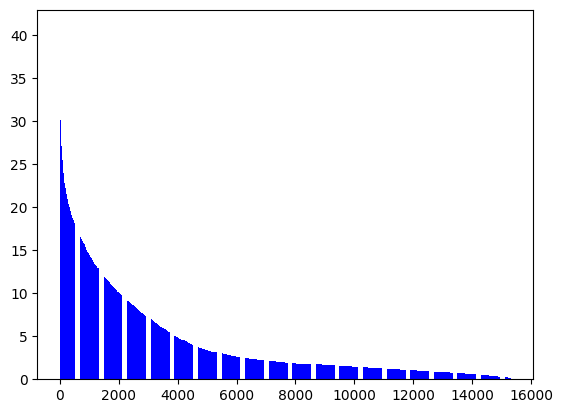

In [57]:
copy = pd.DataFrame()
copy = dataBaseInputPre.copy()
indCliente = pd.DataFrame()

indCliente['ctdComer'] = copy.groupby(['customer_id','semana_dates']).size()
indCliente['pctComer'] = round(100*indCliente['ctdComer']/comUn,2)
indCliente = indCliente.sort_values('pctComer', ascending=False)

plt.bar(range(len(indCliente.index)),indCliente['pctComer'],color='blue')
plt.show()

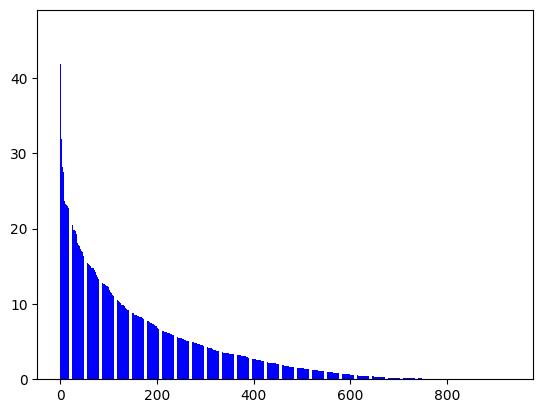

In [58]:
copy = pd.DataFrame()
copy = dataBaseInputPre.copy()
indComer = pd.DataFrame()

indComer['ctdCli'] = copy.groupby(['product_id','semana_dates']).size()
indComer['pctCli'] = round(100*indComer['ctdCli']/cliUn,2)
indComer = indComer.sort_values('pctCli', ascending=False)

plt.bar(range(len(indComer.index)),indComer['pctCli'],color='blue')
plt.show()

In [95]:

# Filtro de Clientes:
filCli = indCliente[(indCliente['pctComer']<=41)].reset_index() ##se puede ajustar este acote (0.025), se añade &(indCliente['pctComer']<=0.95)
filCli = filCli['customer_id'].drop_duplicates()
# Filtro de Comercios:\
filComer = indComer[(indComer['pctCli']>=0.01)&(indComer['pctCli']<=19)].reset_index() ##se puede ajustar este acote (0.025) , se añade &(indCliente['pctCli']<=0.95)
filComer = filComer['product_id'].drop_duplicates()

print('Clientes únicos: '+str(filCli.shape[0]))
print('Productos únicos: '+str(filComer.shape[0]))

dataBaseInput = dataBaseInputPre[dataBaseInputPre['customer_id'].isin(list(filCli))]
dataBaseInput = dataBaseInput[dataBaseInput['product_id'].isin(list(filComer))]
print('Dimensión del Dataset Final: '+str(dataBaseInput.shape[0])+'\n')
dataBaseInput.head()

Clientes únicos: 15312
Productos únicos: 897
Dimensión del Dataset Final: 477748



,customer_id,product_id,rating_1,rating_2,rating_3,rating_4,rating_5,semana_dates
0,1,8,0.000007052254306,0.000000009564328,0.021343001822602,0.000007646037455,0.000000140945186,semana0
101,1,563,0.001065373431356,0.000026224364096,0.003822515304348,0.001953250591597,0.000237637911246,semana0
102,1,568,0.000593548636403,0.000019480412648,0.003669014023020,0.001034533302816,0.000125864205163,semana0
103,1,569,0.000056611246897,0.000000414593945,0.004250406361153,0.000098120755690,0.000003255721262,semana0
104,1,570,0.000062117801629,0.000000454921342,0.004097462944825,0.000113886482626,0.000003778840067,semana0


In [125]:
dataBaseInput['rating']=dataBaseInput['rating_4'] + dataBaseInput['rating_1'] + dataBaseInput['rating_2'] + dataBaseInput['rating_3'] + dataBaseInput['rating_5']
df=dataBaseInput[['customer_id', 'product_id', 'rating']].copy()
df=df.drop_duplicates(subset='product_id', keep='first')
dtf_products = df.set_index('product_id')

# Preprocessing

In [86]:
def logistic_function(x, k, x_0, L):
    """
    k: factor de crecimiento
    x_0: Valor de x donde el resultado sera L/2
    L: valor maximo de la funcion
    """
    return L / (1 + np.exp(-k * (x - x_0)))

train = pd.read_csv('train.csv', sep='|', parse_dates=['fecha_compra'])
train['date_value'] = (train.fecha_compra - train.fecha_compra.min()) / (train.fecha_compra.max() - train.fecha_compra.min()) / 4 + 0.75
# df_max = train.groupby('customer_id').agg(_max=('cantidad_venta', 'max'))
# train = pd.merge(train, df_max, how='left', left_on='customer_id', right_index=True)
# train.cantidad_venta = (train.cantidad_venta) / (train['_max')
train['cantidad_venta_normalizado'] = train.cantidad_venta.apply(lambda x: logistic_function(x, k=2, x_0=0.3, L=1))
train['rating'] = train.cantidad_venta_normalizado * train.date_value
if submit:
    test_fecha_min, test_fecha_max = pd.to_datetime('2023-02-06'), pd.to_datetime('2023-02-12')
else:
    test = train[train.fecha_compra > '2023-01-27']
    test_fecha_min, test_fecha_max = test.fecha_compra.min(), test.fecha_compra.max()
    train = train[train.fecha_compra <= '2023-01-27']
train.sort_values(by=['customer_id', 'product_id', 'fecha_compra'], ascending=[True, True, True], inplace=True)
# train['day'] = train.fecha_compra.dt.day
# train['month'] = train.fecha_compra.dt.month
# train['year'] = train.fecha_compra.dt.year
product = pd.read_csv('RentabilidadProduct.csv', sep='|')
# train = train[(train.fecha_compra > '2022-01-31') & (train.fecha_compra < '2023-02-01')]
submission = pd.read_csv('submit_example.csv', index_col='customer_id')
values = train.groupby(['customer_id', 'product_id']).agg(rating = ('rating', 'sum'), ultima_fecha = ('fecha_compra', 'max'))
if not submit:
    values_test = test.groupby(['customer_id', 'product_id']).agg(rating = ('rating', 'sum'), ultima_fecha = ('fecha_compra', 'max'))
matrix = pd.pivot_table(values, index='customer_id', columns='product_id', values='rating')
std = train.groupby(['customer_id', 'product_id'])['fecha_compra'].diff()
product = pd.merge(product, train.drop_duplicates(subset=['product_id', 'business_id'])[['product_id','business_id']], how='right', on='product_id')
product['std'] = product.product_id.apply(lambda iid: std.loc[train[train.product_id == iid].index].std().days)

propenso = train.groupby(['customer_id']).product_id.agg(['nunique','count'])
propenso['propenso'] = propenso['nunique'] / propenso['count']
propenso = propenso.drop(['nunique','count'], axis=1)

customers = train.drop_duplicates('customer_id')[['customer_id','type_id']].copy().reset_index(drop=True)
customers.set_index('customer_id', inplace=True)
customers['propenso'] = 1 - propenso

def get_product_similarity(iid_1, iid_2, by):
    similarity = product.loc[product.product_id == iid_1, by].iloc[0] == product.loc[product.product_id == iid_2, by].iloc[0]
    return int(similarity)

# Test

In [4]:
def get_recall(comprados, recomendados):
    if comprados.shape[0] == 0:
        return 1.
    recall = np.intersect1d(comprados, recomendados, assume_unique=True).shape[0] / comprados.shape[0]
    return recall

def get_user_comprados(uid, dataset):
    """
    Retornar los productos que un usuario ha comprado en el dataset train o test
    """
    comprados = dataset[dataset.customer_id == uid].product_id.unique()
    return comprados

def get_user_recall_submission(uid, comprados):
    recomendados_submission = np.array(submission.loc[uid].str.split()[0][:30]).astype('int')
    recall = get_recall(comprados, recomendados_submission)
    return recall

# KDE

In [130]:
bw_method = 0.75
def plot_fechas_customer_product(uid, iid):
    fechas_compra = train[(train.customer_id == uid) & (train.product_id == iid)].fecha_compra
    # Crear una serie temporal con las fechas de compra como índice (esto puede ser útil para análisis posteriores)
    serie_temporal = pd.Series(data=[1] * len(fechas_compra), index=fechas_compra)
    # Visualizar la serie temporal
    plt.figure(figsize=(10, 4))
    plt.plot(serie_temporal.index, serie_temporal.values, marker='o')
    plt.xlabel('Fecha')
    plt.ylabel('Compras')
    plt.title('Compras por fecha')
    plt.grid(True)
    plt.show()
    
def plot_kde_diferencias_fecha_customer_product(uid, iid):
    fechas_compra = train[(train.customer_id == uid) & (train.product_id == iid)].fecha_compra
    diferencias = fechas_compra.diff()[1:].dt.days
    kde = gaussian_kde(diferencias, bw_method=bw_method)
    x = np.linspace(0, diferencias.max()*2, 100)
    print(diferencias.values)
    sns.lineplot(x=x, y=kde(x))

def get_probability_customer_product(uid, iid, min_n, max_n):
    """
    Calcula la probabilidad de que un cliente uid compre cierto producto iid entre los (min_n, max_n) dias siguientes
    """
    #print(f'uid={uid}, iid={iid}')
    fechas = train[(train.customer_id == uid) & (train.product_id == iid)].fecha_compra
    if fechas.count() == 0:
        return 0
    diferencias = fechas.diff()[1:].dt.days
    if diferencias.shape[0] <= 8:
        return 0
    if diferencias.shape[0] <= 1 or diferencias.nunique() == 1 :
        distribucion_normal = norm(loc=diferencias.mean(), scale=100/diferencias.shape[0])
        probability_less_than_n = distribucion_normal.cdf(max_n + 0.5) - distribucion_normal.cdf(min_n - 0.5)
    else:
        kde = gaussian_kde(diferencias, bw_method=bw_method)
        probability_less_than_n = quad(kde, min_n-0.5, max_n+0.5)[0]
        if probability_less_than_n == 0:
            return 0.000000000001
    return probability_less_than_n * values.loc[(uid, iid), 'rating']

def get_probability_customer_product_fechas(uid, iid, fecha_min, fecha_max):
    """
    Calcula la probabilidad de que un cliente uid compre un producto iid en las fechas dadas
    Estas fechas tienen que ser despues de su ultima compra
    """
    try:
        ultima_fecha = values.loc[(uid, iid), 'ultima_fecha']
    except KeyError:
        return 0
    n_min = (fecha_min - ultima_fecha).days
    n_max = (fecha_max- ultima_fecha).days
    
    return get_probability_customer_product(uid, iid, n_min, n_max)

def get_kde_recomendados(uid, fecha_min, fecha_max):
    """
    Retorna los recomendados para un cliente uid en las fechas dadas
    """
    probabilidades = [[iid, get_probability_customer_product_fechas(uid, iid, fecha_min, fecha_max)] for iid in matrix.columns]
    recomendados = np.array(list(map(lambda x:x[0], sorted(probabilidades, key=lambda x:x[1], reverse=True)[:30])))
    return recomendados

def get_kde_recomendados_with_probabilities(uid, fecha_min, fecha_max):
    """
    Retorna los recomendados para un cliente uid en las fechas dadas
    """
    probabilidades = [[iid, get_probability_customer_product_fechas(uid, iid, fecha_min, fecha_max)] for iid in matrix.columns]
    recomendados = np.array(sorted(probabilidades, key=lambda x:x[1], reverse=True)[:30])
    iid_probability = pd.DataFrame(recomendados, columns=['iid', 'probability'])
    iid_probability.iid = iid_probability.iid.astype(int)
    return iid_probability

def get_union_recomendados(uid, fecha_min, fecha_max, kde_weight, cf_weight):

    df_cf = pd.DataFrame(get_user_top_n_2_with_rating(uid), columns=['iid', 'probability'])
    cf_min, cf_max = df_cf.probability.min(), df_cf.probability.max()
    df_cf.probability = (df_cf.probability - cf_min) / cf_max

    df_kde = get_kde_recomendados_with_probabilities(uid, fecha_min, fecha_max)
    kde_min, kde_max = df_kde.probability.min(), df_kde.probability.max()
    df_kde.probability = (df_kde.probability - kde_min) / kde_max

    df_kde.probability = df_kde.probability * kde_weight
    df_cf.probability = df_cf.probability * cf_weight

    recomendados = pd.concat([df_kde, df_cf], ignore_index=True).groupby('iid').sum().sort_values('probability', ascending=False).index[:30]
    return recomendados

# COLLABORATIVE FILTERING

In [97]:
values_reset = dataBaseInput[['customer_id','product_id','rating']].reset_index(drop=True)
reader = Reader(line_format='user item rating timestamp', rating_scale=(0, values_reset.rating.max()))
data = Dataset.load_from_df(values_reset, reader)
train_set = data.build_full_trainset()
if not submit:
    test_set = values_test.reset_index().drop('ultima_fecha', axis=1).values.tolist()
algo = SVD(n_factors=200, n_epochs=40, init_mean=0, init_std_dev=0.1)
algo.fit(train_set)

In [98]:
data = Dataset.load_from_df(values_reset[:100000], reader)
y = cross_validate(algo, data, verbose=True, measures=['rmse'])

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0615  0.0621  0.0628  0.0630  0.0652  0.0629  0.0013  
Fit time          2.78    2.77    2.76    2.79    3.13    2.84    0.14    
Test time         0.11    0.11    0.11    0.12    0.15    0.12    0.01    


In [8]:
predictions = algo.test(values.reset_index().drop('ultima_fecha', axis=1).values.tolist())
rmse(predictions)

RMSE: 3.3840


3.3839997128898065

In [80]:
def get_top_n(predictions, n=30):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def get_user_top_n_2(uid):
    """
    Retornar los 50 productos con mayor probabilidad para un usuario uid
    """
    predictions = list()
    for iid in matrix.columns:
        if np.isnan(matrix.loc[uid, iid]):
            prediction = algo.predict(uid, iid)
        else:
            prediction = Prediction(uid, iid, matrix.loc[uid,iid], matrix.loc[uid,iid], dict())
        predictions.append(prediction)
    top_n = get_top_n(predictions, n=30)
    top_n_iid = [iid for (iid, rating) in top_n[uid]]
    recomendados = np.array(top_n_iid)
    return recomendados

def get_user_top_n_2_with_rating(uid):
    """
    Retornar los 50 productos con mayor probabilidad para un usuario uid
    """
    predictions = list()
    for iid in matrix.columns:
        if np.isnan(matrix.loc[uid, iid]):
            prediction = algo.predict(uid, iid)
        else:
            prediction = Prediction(uid, iid, matrix.loc[uid,iid], matrix.loc[uid,iid], dict())
        predictions.append(prediction)
    top_n = get_top_n(predictions, n=30)
    return top_n[uid]

# TESTING

In [129]:
start = time.time()
recall_kde_sum = 0
recall_CF_sum = 0
recall_unidos_sum = 0
n = 30
#for uid in matrix.index[:n]:\
for uid in customers[customers.index.isin(test.customer_id.unique())].sort_values('propenso', ascending=False)[:n].index:
#for uid in np.random.choice(matrix.index, size=n):
#for uid in test.groupby('customer_id').product_id.count().sort_values()[-n:].index:
    propenso = customers.loc[uid, 'propenso']
    comprados = get_user_comprados(uid, test)
    recomendados = get_kde_recomendados(uid, test_fecha_min, test_fecha_max)
    recomendados_CF = get_user_top_n_2(uid)
    recomendados_unidos = get_union_recomendados(uid, test_fecha_min, test_fecha_max, kde_weight=5+propenso, cf_weight=2-propenso)
    recall_kde_sum += get_recall(comprados, recomendados)
    recall_CF_sum += get_recall(comprados, recomendados_CF)
    recall_unidos_sum += get_recall(comprados, recomendados_unidos)
print(f'avg kde: {recall_kde_sum/n}, avg CF: {recall_CF_sum/n}, avg unidos: {recall_unidos_sum/n}')
end = time.time()
print(f'time: {end - start}')
print(f'comprados: {comprados}')
print(f'recomendados: {recomendados}')
print(f'recomendados_CF: {recomendados_CF}')
print(f'recomendados_CF y KDE: {np.intersect1d(recomendados, recomendados_CF)}')
print(f'comprados y recomendados: {np.intersect1d(comprados, recomendados)}')
print(f'comprados y recomendados_CF: {np.intersect1d(comprados, recomendados_CF)}')
print(f'comprados y no recomendados: {np.setdiff1d(comprados, recomendados)}')
print(f'comprados y no recomendados_CF: {np.setdiff1d(comprados, recomendados_CF)}')
print(f'recomendados y comprados por CF y no KDE: {np.setdiff1d(np.intersect1d(recomendados_CF, comprados), recomendados)}')
print(f'nuevos comprados: {np.setdiff1d(comprados, get_user_comprados(uid, train))}')
print(f'cantidad de productos unicos comprados: {get_user_comprados(uid, train).shape[0]}')
print(f'propenso: {customers.loc[uid, "propenso"]}')

avg kde: 0.8935185185185187, avg CF: 0.9490740740740741, avg unidos: 0.9490740740740741
time: 9.947692394256592
comprados: [672  33]
recomendados: [ 33 672   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28]
recomendados_CF: [ 33 672 739  31 163  32 210 149  35 213  34 688 211  42 164 193 673 691
 709  38 609 168 713 608 244 683 728  72 607 208]
recomendados_CF y KDE: [ 33 672]
comprados y recomendados: [ 33 672]
comprados y recomendados_CF: [ 33 672]
comprados y no recomendados: []
comprados y no recomendados_CF: []
recomendados y comprados por CF y no KDE: []
nuevos comprados: []
cantidad de productos unicos comprados: 3
propenso: 0.9651162790697675


In [ ]:
customers.sort_values('propenso')

In [ ]:
customers.sort_values('propenso').index[:30]

In [114]:
test[test.customer_id.isin(customers.sort_values('propenso').index[:30])]

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,date_value,cantidad_venta_normalizado,rating
2124411,2023-01-28,15201,66,GA,51,V,1.0,22.273479991709412,2.862492463712278,0.995257452574526,0.802183888558582,0.798379493423141
2129598,2023-01-30,14554,772,GA,54,V,1.0,7.616522726564526,1.736949310505023,0.996612466124661,0.802183888558582,0.799466463461839
2130333,2023-01-30,14554,39,GA,51,V,1.0,12.016794313177250,1.325292323915333,0.996612466124661,0.802183888558582,0.799466463461839
2130806,2023-01-30,14554,610,GA,22,V,9.0,16.796299832583575,0.521084793151507,0.996612466124661,0.999999972249168,0.996612438467836
2151828,2023-02-02,14798,163,GA,51,V,2.0,21.370266350246801,2.315932414006697,0.998644986449865,0.967704535301549,0.966393282543688
2160985,2023-02-04,9203,657,BO,21,V,1.0,0.720833963859585,0.289491551750837,1.000000000000000,0.802183888558582,0.802183888558582
2162074,2023-02-04,9203,856,BO,21,V,1.0,1.702210324294923,0.074399328799965,1.000000000000000,0.802183888558582,0.802183888558582
2162096,2023-02-04,9203,576,BO,21,V,3.0,1.736949310505023,0.108559331906564,1.000000000000000,0.995503726839059,0.995503726839059
2165190,2023-02-04,9203,52,BO,21,V,3.0,7.648366797257119,0.715623115928069,1.000000000000000,0.995503726839059,0.995503726839059
2165395,2023-02-04,7237,689,PA,31,B,1.0,8.282353295591452,1.447457758754186,1.000000000000000,0.802183888558582,0.802183888558582


In [82]:
get_kde_recomendados(1, test_fecha_min, test_fecha_max)

array([ 414,  459,  456,   21,  453,  404,  418,  406,  428,  194,  452,
        203,  426,  608,  417,  572, 1028,  405,  202,  809,  926,  337,
        119,  190,   27,  811,  997,  573,  120,   52])

In [81]:
get_user_top_n_2(1)

array([ 452,  414,  456,   21,  404,  459,  453,  426,  418,  406,  428,
        417, 1028,  608,  202,  496,  926,  405,  203,  194,  120,  635,
        890,  337,  334,  316,  997,  119,  659,  116])

In [84]:
np.setdiff1d(get_user_top_n_2(1),get_kde_recomendados(1, test_fecha_min, test_fecha_max) )

array([116, 316, 334, 496, 635, 659, 890])

In [83]:
np.intersect1d(get_kde_recomendados(1, test_fecha_min, test_fecha_max), get_user_top_n_2(1))

array([  21,  119,  120,  194,  202,  203,  337,  404,  405,  406,  414,
        417,  418,  426,  428,  452,  453,  456,  459,  608,  926,  997,
       1028])

In [32]:
submission.drop(index=[1,2,3,4,5], inplace=True)

In [33]:
for uid in customers.index.astype('str').sort_values().astype('int64')[:3000]:
    recomendados = get_kde_recomendados(uid, test_fecha_min, test_fecha_max)
    submission.at[uid, 'product_id'] = ' '.join(map(str, recomendados))

In [39]:
train[train.customer_id == 4401]

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,date_value,cantidad_venta_normalizado,rating
426336,2022-04-18,4401,178,GA,51,V,4.0,50.015455395992142,11.579662070033487,0.802168021680217,0.999389120640566,0.801677993792974
669471,2022-05-30,4401,178,GA,51,V,2.0,25.512890455801280,5.789831035016744,0.830623306233062,0.967704535301549,0.803797940568902
840699,2022-06-27,4401,178,GA,51,V,3.0,39.298478150176152,8.684746552525116,0.849593495934959,0.995503726839059,0.845773491501477
919042,2022-07-11,4401,178,GA,51,V,2.0,26.471107492096550,5.789831035016744,0.859078590785908,0.967704535301549,0.831334248483987
1075507,2022-08-08,4401,178,GA,51,V,2.0,26.471107492096550,5.789831035016744,0.878048780487805,0.967704535301549,0.849691787094043
1199279,2022-08-29,4401,178,GA,51,V,2.0,26.471107492096550,5.789831035016744,0.892276422764228,0.967704535301549,0.863459941051586
1329004,2022-09-19,4401,178,GA,51,V,2.0,26.714280395567251,5.789831035016744,0.906504065040650,0.967704535301549,0.877228095009128
1500424,2022-10-17,4401,178,GA,51,V,2.0,26.714280395567251,5.789831035016744,0.925474254742547,0.967704535301549,0.895585633619185
1626504,2022-11-07,4401,178,GA,51,V,2.0,26.714280395567251,5.789831035016744,0.939701897018970,0.967704535301549,0.909353787576727
1758400,2022-11-28,4401,178,GA,51,V,2.0,26.552165126586782,5.789831035016744,0.953929539295393,0.967704535301549,0.923121941534269


In [37]:
values

rating ultima_fecha
customer_id product_id                                 
1           8            0.661421268547286   2022-05-21
            11           4.323341916855737   2022-09-10
            21          17.401667082984037   2023-01-28
            25           2.282294844661918   2022-12-17
            27           5.836546118343962   2022-12-17
...                                    ...          ...
15312       672          1.741687678877901   2023-01-21
            739          1.750866448182929   2023-02-04
            772          3.663328595523457   2023-02-04
            813          0.783161912881379   2022-12-31
            976          0.783161912881379   2022-12-31

[668425 rows x 2 columns]

In [34]:
submission.to_csv('submit.csv')

In [8]:
get_kde_recomendados(1, test_fecha_min, test_fecha_max)

array([ 414,  459,  456,   21,  453,  404,  418,  406,  428,  194,  452,
        203,  426,  608,  417,  572, 1028,  405,  202,  809,  926,  337,
        119,  190,   27,  811,  997,  573,  120,   52])

In [17]:
train.customer_id.nunique()

15312

In [29]:
product.shape[0] - 111

932

In [30]:
values

rating ultima_fecha
customer_id product_id                                 
1           8            0.661421268547286   2022-05-21
            11           4.323341916855737   2022-09-10
            21          17.401667082984037   2023-01-28
            25           2.282294844661918   2022-12-17
            27           5.836546118343962   2022-12-17
...                                    ...          ...
15312       672          1.741687678877901   2023-01-21
            739          1.750866448182929   2023-02-04
            772          3.663328595523457   2023-02-04
            813          0.783161912881379   2022-12-31
            976          0.783161912881379   2022-12-31

[668425 rows x 2 columns]